In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R
import seaborn as sns
import matplotlib as mpl
import scipy.stats as stats

from matplotlib.collections import LineCollection

In [2]:
def euclid(a,b):
    dim = max(len(a.shape), len(b.shape))
    if dim == 1:
        # a, b are just two points
        axis = 0
    elif dim == 2:
        # a and/or b are lists of points
        axis = 1
    else:
        raise ValueError()
    
    d_squared = np.sum((a-b)**2, axis=axis)
    return np.sqrt(d_squared)

def taxicab(a,b):
    return np.sum(np.abs(a-b), axis=1)

def chebyshev(a,b):
    return np.max(np.abs(a-b), axis=1)

def d(a,b):
    """The metric distance between points a and b"""
    a = np.asarray(a)
    b = np.asarray(b)
    return euclid(a,b)

def distances_to_point(p, other_points):
    """Calculates the distance from `p` to all `other_points`"""
    return euclid(p, other_points)

METRIC_NAME = r"\|.\|_\infty"

In [3]:
def to_pivot_space(point, pivots):
    return np.asarray([d(piv, point) for piv in pivots])

def slow_points_to_pivot_space(points, pivots):
    return np.asarray([to_pivot_space(pt, pivots) for pt in points])

def points_to_pivot_space(points, pivots):
    n_points = points.shape[0]
    n_dim = len(pivots)
    transformed = np.empty([n_points, n_dim])
    for dim, pv in enumerate(pivots):
        transformed[:, dim] = distances_to_point(pv, points)
    return transformed

In [4]:
pivots = np.asarray([[-0.5,0], [0.5,0]])

In [5]:
def fill_rectangle(x_lim, y_lim, n):
    """Return about `n` points that are inside the given rectangle"""
    samples = int(np.sqrt(n))
    x = np.linspace(*x_lim, samples)
    y = np.linspace(*y_lim, samples)
    xx, yy = np.meshgrid(x,y)
    points = np.array([xx.flatten(), yy.flatten()]).T
    return points

In [6]:
def normal(n=1000):
    return np.random.normal(loc=0.5, scale=0.05, size=n)
circle = np.asarray([0.2+normal(),0.2+normal()]).T

In [7]:
def fill_circle(radius, n):
    bounds = (-radius, radius)
    points = fill_rectangle(bounds, bounds, n)
    distance_to_center = np.sum(points**2, axis=1)
    return points[distance_to_center<=radius**2]

def move_points(points, delta_x, delta_y):
    points = points.copy()
    points[:,0] += delta_x
    points[:,1] += delta_y
    return points

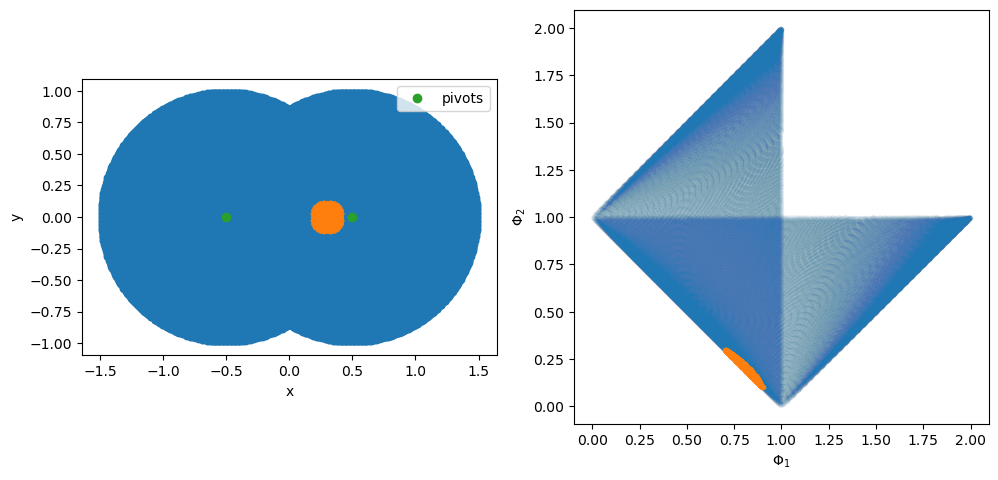

In [8]:
def circle_around_point(radius, point, n):
    c = fill_circle(radius, n)
    return move_points(c, *point)

points = np.vstack([
    circle_around_point(1, piv, 100000)
    for piv in pivots
])


circle = fill_circle(0.1, 1000)
circle[:,0] += 0.3

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.xlabel("x")
plt.ylabel("y")

plt.plot(*points.T, ".");
plt.plot(*circle.T, "x");
plt.plot(*pivots.T, "o", label="pivots")
plt.legend();

plt.gca().set_aspect('equal')


plt.subplot(1,2,2)
plt.xlabel("$\Phi_1$")
plt.ylabel("$\Phi_2$")

points_piv = points_to_pivot_space(points, pivots)
plt.plot(*points_piv.T, ".", alpha=0.01);

circle_piv = points_to_pivot_space(circle, pivots)
plt.plot(*circle_piv.T, ".");

plt.tight_layout()
plt.gca().set_aspect('equal')

In [9]:
def rot_2d(radians):
    """returns a rotation matrix"""
    rot = R.from_rotvec(np.array([0,0,radians])).as_matrix()
    rot = rot[0:2,0:2]
    return rot
    
def rectify_transform(pivots, points_in_ps):
    """rotates and translates points in the pivots space into a "normal" position.
    """ 
    assert len(pivots) == 2, "Not implemented for higher dimensions"
    piv_dist = d(*pivots)
    base_length = np.sqrt(2) * piv_dist
    proj = points_piv - 0.5 * np.array([piv_dist, piv_dist])
    proj = proj @ rot_2d(np.pi/4)
    proj += np.array([base_length / 2,0])
    return proj


In [10]:
points = np.vstack([
    circle_around_point(1, piv, 1000)
    for piv in pivots
])
points = np.unique(points, axis=1)

<bound method Axes.fill_between of <Axes: >>

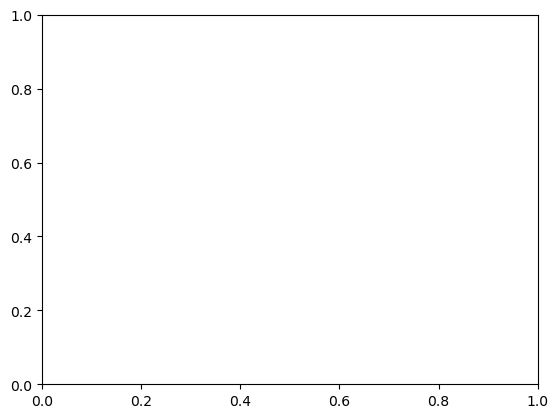

In [11]:
plt.gca().fill_between

(-1.0, 2.0)

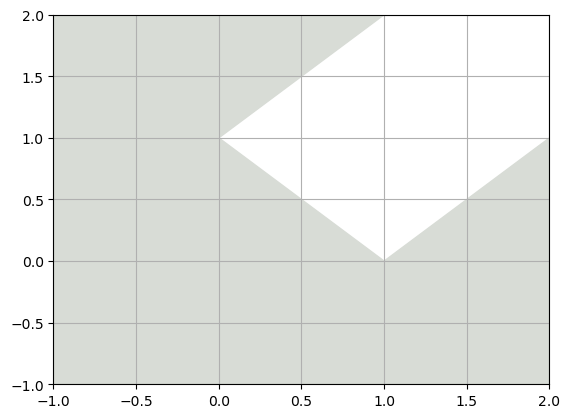

In [12]:
def mask_forbidden(pivots, ax=None):
    """Plot a gray area where the pivot space is inaccessible.

    This region does not have an preimage, as can easily be seen
    by using the triangle inequality, with both pivots being two
    points of the triangle.
    """
    if ax is None:
        ax=plt.gca()
    
    def mask(*args, **kwargs):
        return ax.fill_between(*args,**kwargs,color="xkcd:light grey",)
    
    p_1, p_2 = points_to_pivot_space(pivots, pivots)
    b = p_2[0]
    m = -1
    inacc_below = lambda x: m*x+b

    # we don't want to influence the existing limits
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    
    x = np.linspace(-10,10)
    y = inacc_below(x)
    mask(x, y, y - 100)

    m = +1
    inacc_above = lambda x: m*x+b
    y = inacc_above(x)
    mask(x, y, y + 100)

    inacc_below = lambda x: m*x-b
    y = inacc_below(x)
    mask(x, y-100, y)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


mask_forbidden(pivots)
plt.grid();
plt.xlim(-1,2)
plt.ylim(-1,2)

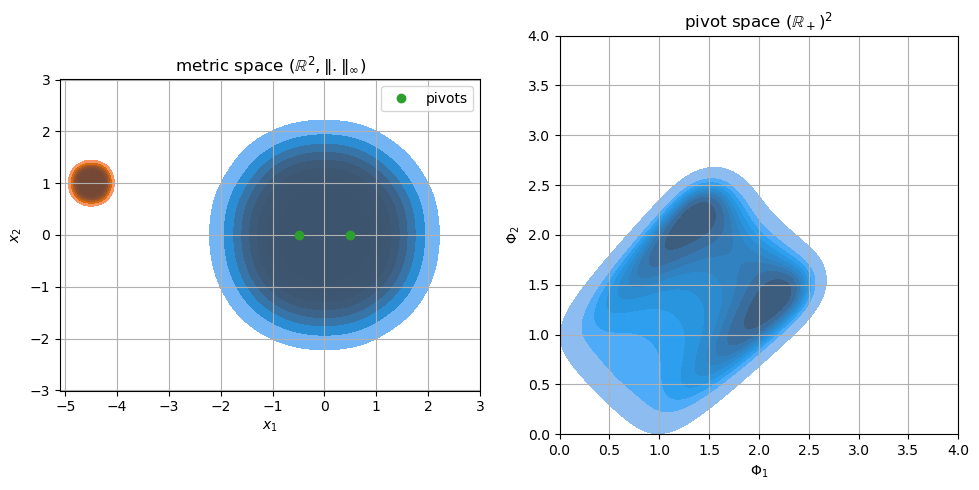

In [13]:
points = fill_circle(2, 1000)#fill_rectangle((-2,2), (-2,2), 1000)

circle = fill_circle(0.4, 1000)
circle = move_points(circle, -4.5,1)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title(r"metric space $(\mathbb{R}^2, "+METRIC_NAME+")$")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

sns.kdeplot(x=points[:,0], y=points[:,1], fill=True)
sns.kdeplot(x=circle[:,0], y=circle[:,1], fill=True)
plt.plot(*pivots.T, "C2o", label="pivots")
plt.legend();
plt.gca().set_aspect('equal')
plt.grid()

plt.subplot(1,2,2)
plt.title("pivot space $(\mathbb{R}_+)^2$")
plt.xlabel("$\Phi_1$")
plt.ylabel("$\Phi_2$")

#

points_piv = points_to_pivot_space(points, pivots)
sns.kdeplot(x=points_piv[:,0], y=points_piv[:,1], fill=True)

circle_piv = points_to_pivot_space(circle, pivots)
plt.plot(*circle_piv.T, "C1o")

#sns.kdeplot(x=circle_piv[:,0], y=circle_piv[:,1], fill=True)

plt.xlim(0,4)
plt.ylim(0,4)
#plt.hexbin(*points_piv.T,bins=100)
plt.grid()
plt.tight_layout()
plt.gca().set_aspect('equal')

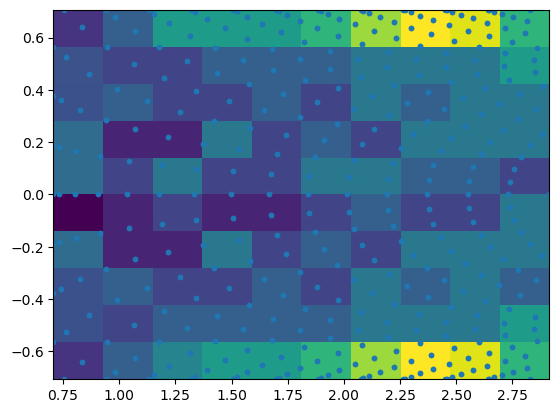

In [14]:
points_rp = rectify_transform(pivots, points_piv)

plt.plot(*points_rp.T, ".", alpha=1);
plt.hist2d(*points_rp.T, density=True);

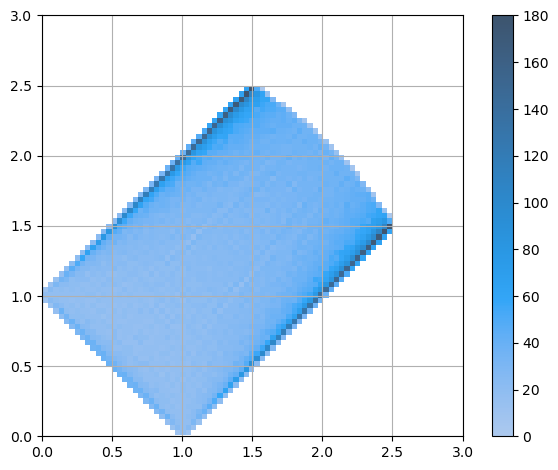

In [15]:
points = fill_circle(2, 100000)

#mask_forbidden(pivots)

points_piv = points_to_pivot_space(points, pivots)
#sns.kdeplot(x=points_piv[:,0], y=points_piv[:,1], fill=True)

circle_piv = points_to_pivot_space(circle, pivots)
plt.plot(*circle_piv.T, "C1o")

#sns.kdeplot(x=circle_piv[:,0], y=circle_piv[:,1], fill=True)

#plt.hist2d(*points_piv.T,bins=[100,100])
sns.histplot(x=points_piv[:,0], y=points_piv[:,1],  cbar=True)

plt.xlim(0,3)
plt.ylim(0,3)

plt.grid()
plt.tight_layout()
plt.gca().set_aspect('equal')

In [16]:
points = stats.multivariate_normal(mean=[0,0]).rvs(10_000_000)
points_piv = points_to_pivot_space(points, pivots)
points_rp = rectify_transform(pivots, points_piv)

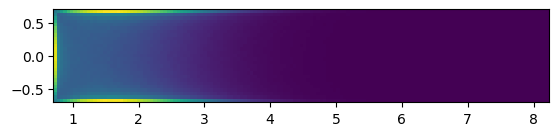

In [17]:
def binspace(vals, bin_length = 0.05):
    """generates bin edges that are guaranteed to be between vals.min and vals.max
    The actual bin_length can be off by a little bit to accomplish this.""" 
    space = vals.max() - vals.min()
    steps = int(space / bin_length)
    return np.linspace(vals.min(), vals.max()+1e-6, steps)
    
bins = binspace(points_rp[:,0]), binspace(points_rp[:,1])

plt.hist2d(*points_rp.T, bins=bins, density=True) #, norm=mpl.colors.LogNorm());
plt.gca().set_aspect('equal')
plt.show()

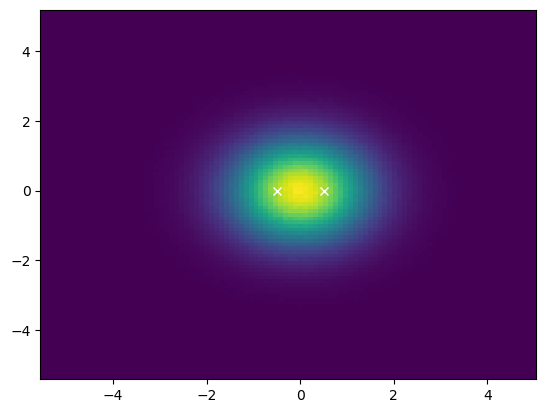

In [18]:
plt.hist2d(*points.T, bins=100)
plt.plot(*pivots.T, "x", color="white", label="pivots");

In [19]:
import sys
sys.path.append("..")

from pivot import metric
from pivot.transform import PivotSpace
from pivot.plot import plot_grid

In [119]:
piv.

In [129]:
from contextlib import contextmanager

class PivotSpaceVisualizer:
    def __init__(self, piv_space:PivotSpace, save_path=""):
        self.piv = piv_space
        self.save_path = save_path

    def plot(self, fname, plot_in_metric_space_func, plot_in_pivot_space_func):
        fig = plt.figure(figsize=(10,5), dpi=300)

        with self._plot_metric_space(fig) as ax:
            plot_in_metric_space_func(ax)

        with self._plot_pivot_space(fig) as ax:
            plot_in_pivot_space_func(ax)

        fig.tight_layout()
        fig.savefig(self.save_path + fname)

    @contextmanager
    def _plot_metric_space(self, fig):
        ax = fig.add_subplot(1,2,1)
        ax.set_title(r"metric space $(\mathbb{R}^2, "+piv.metric.name+")$")
        ax.set_xlabel("$x_1$")
        ax.set_ylabel("$x_2$")

        yield ax

        ax.plot(*self.piv.pivots.T, "o", color="C2", label="pivots");
        ax.set_ylim(-1.1,1.1)
        ax.legend()
        ax.set_aspect('equal')

    @contextmanager
    def _plot_pivot_space(self, fig):
        ax = fig.add_subplot(1,2,2)
        ax.set_title(r"pivot space $(\mathbb{R}_+)^2$")
        ax.set_xlabel("$\Phi_1$")
        ax.set_ylabel("$\Phi_2$")

        yield ax

        mask_forbidden(pivots)
        ax.plot(*self.piv.transform_points(self.piv.pivots), "o", color="C2", label="pivots");
        ax.set_aspect('equal')

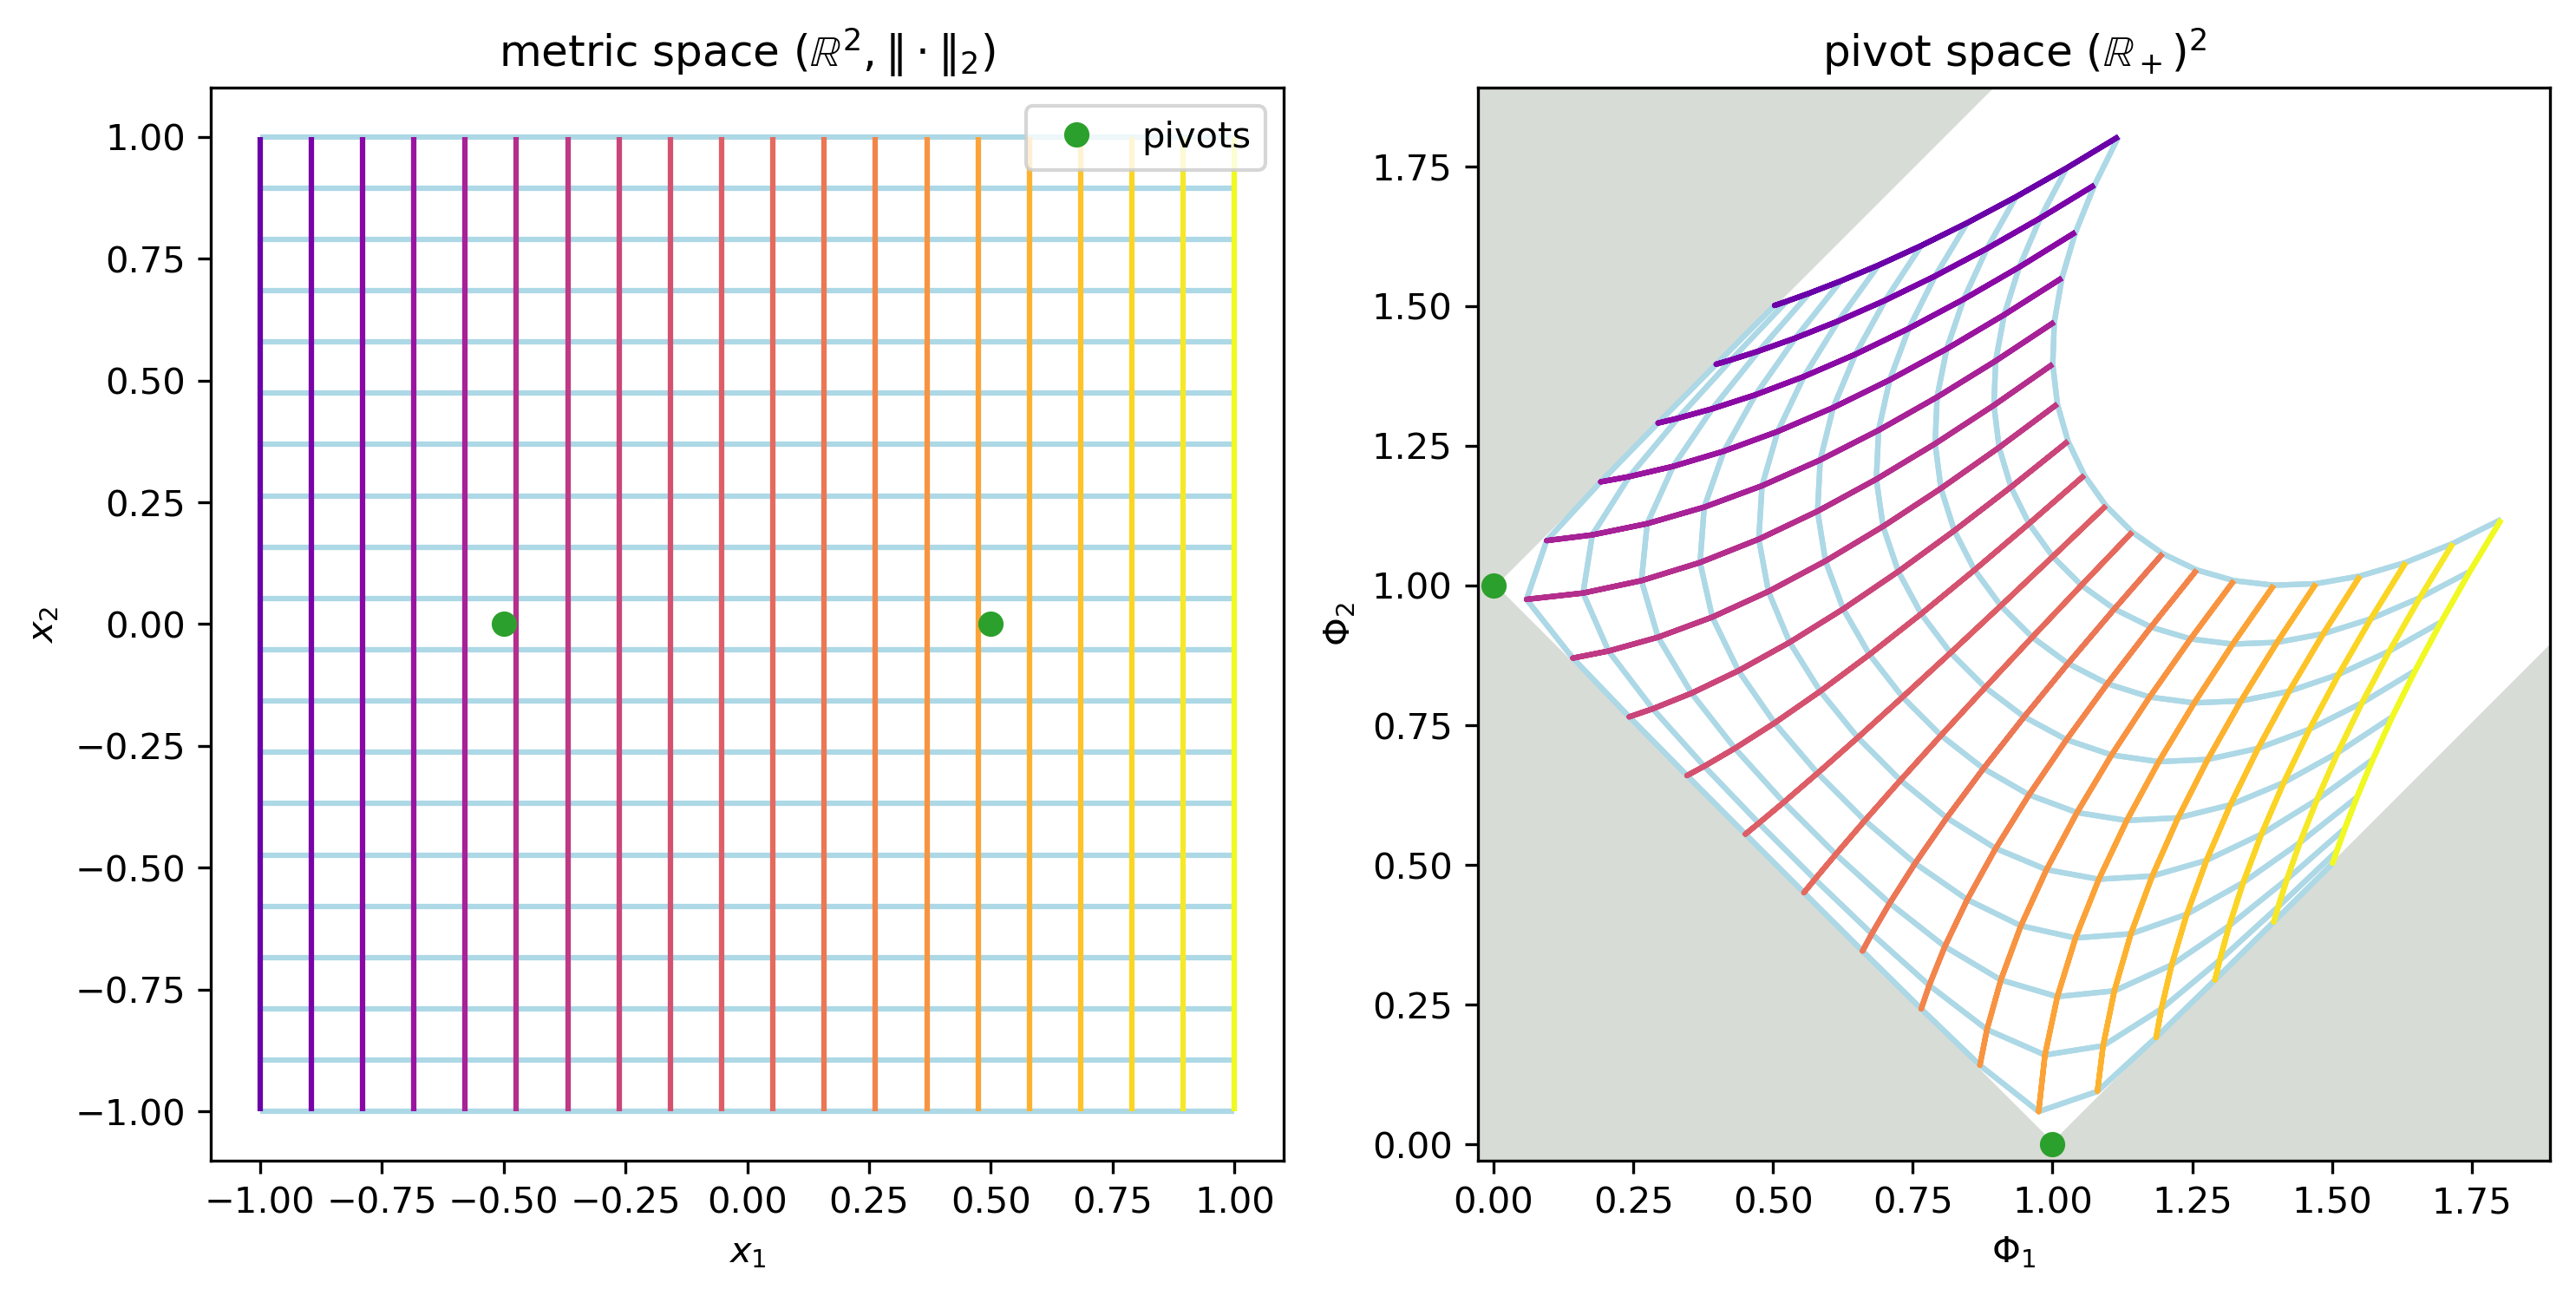

In [130]:
piv = PivotSpace(metric.Euclid(),pivots)
viz = PivotSpaceVisualizer(piv, "/fig/")

n = 20
xx, yy = np.meshgrid(np.linspace(-1,1, n), np.linspace(-1, 1,n))

points = np.array([xx.flatten(), yy.flatten()]).T
p_t = piv.transform_points(points)
xx_t, yy_t = p_t.T
xx_t = xx_t.reshape(xx.shape)
yy_t = yy_t.reshape(yy.shape)

cmap_1 = mpl.colormaps['plasma']
config = dict(
    ycolor = cmap_1(np.linspace(0.2,1, xx.shape[0])),
    xcolor = "lightblue",
)

viz.plot(
    "r_2_grid.svg",
    lambda ax: plot_grid(xx,yy, **config),
    lambda ax: plot_grid(xx_t,yy_t, **config),
)

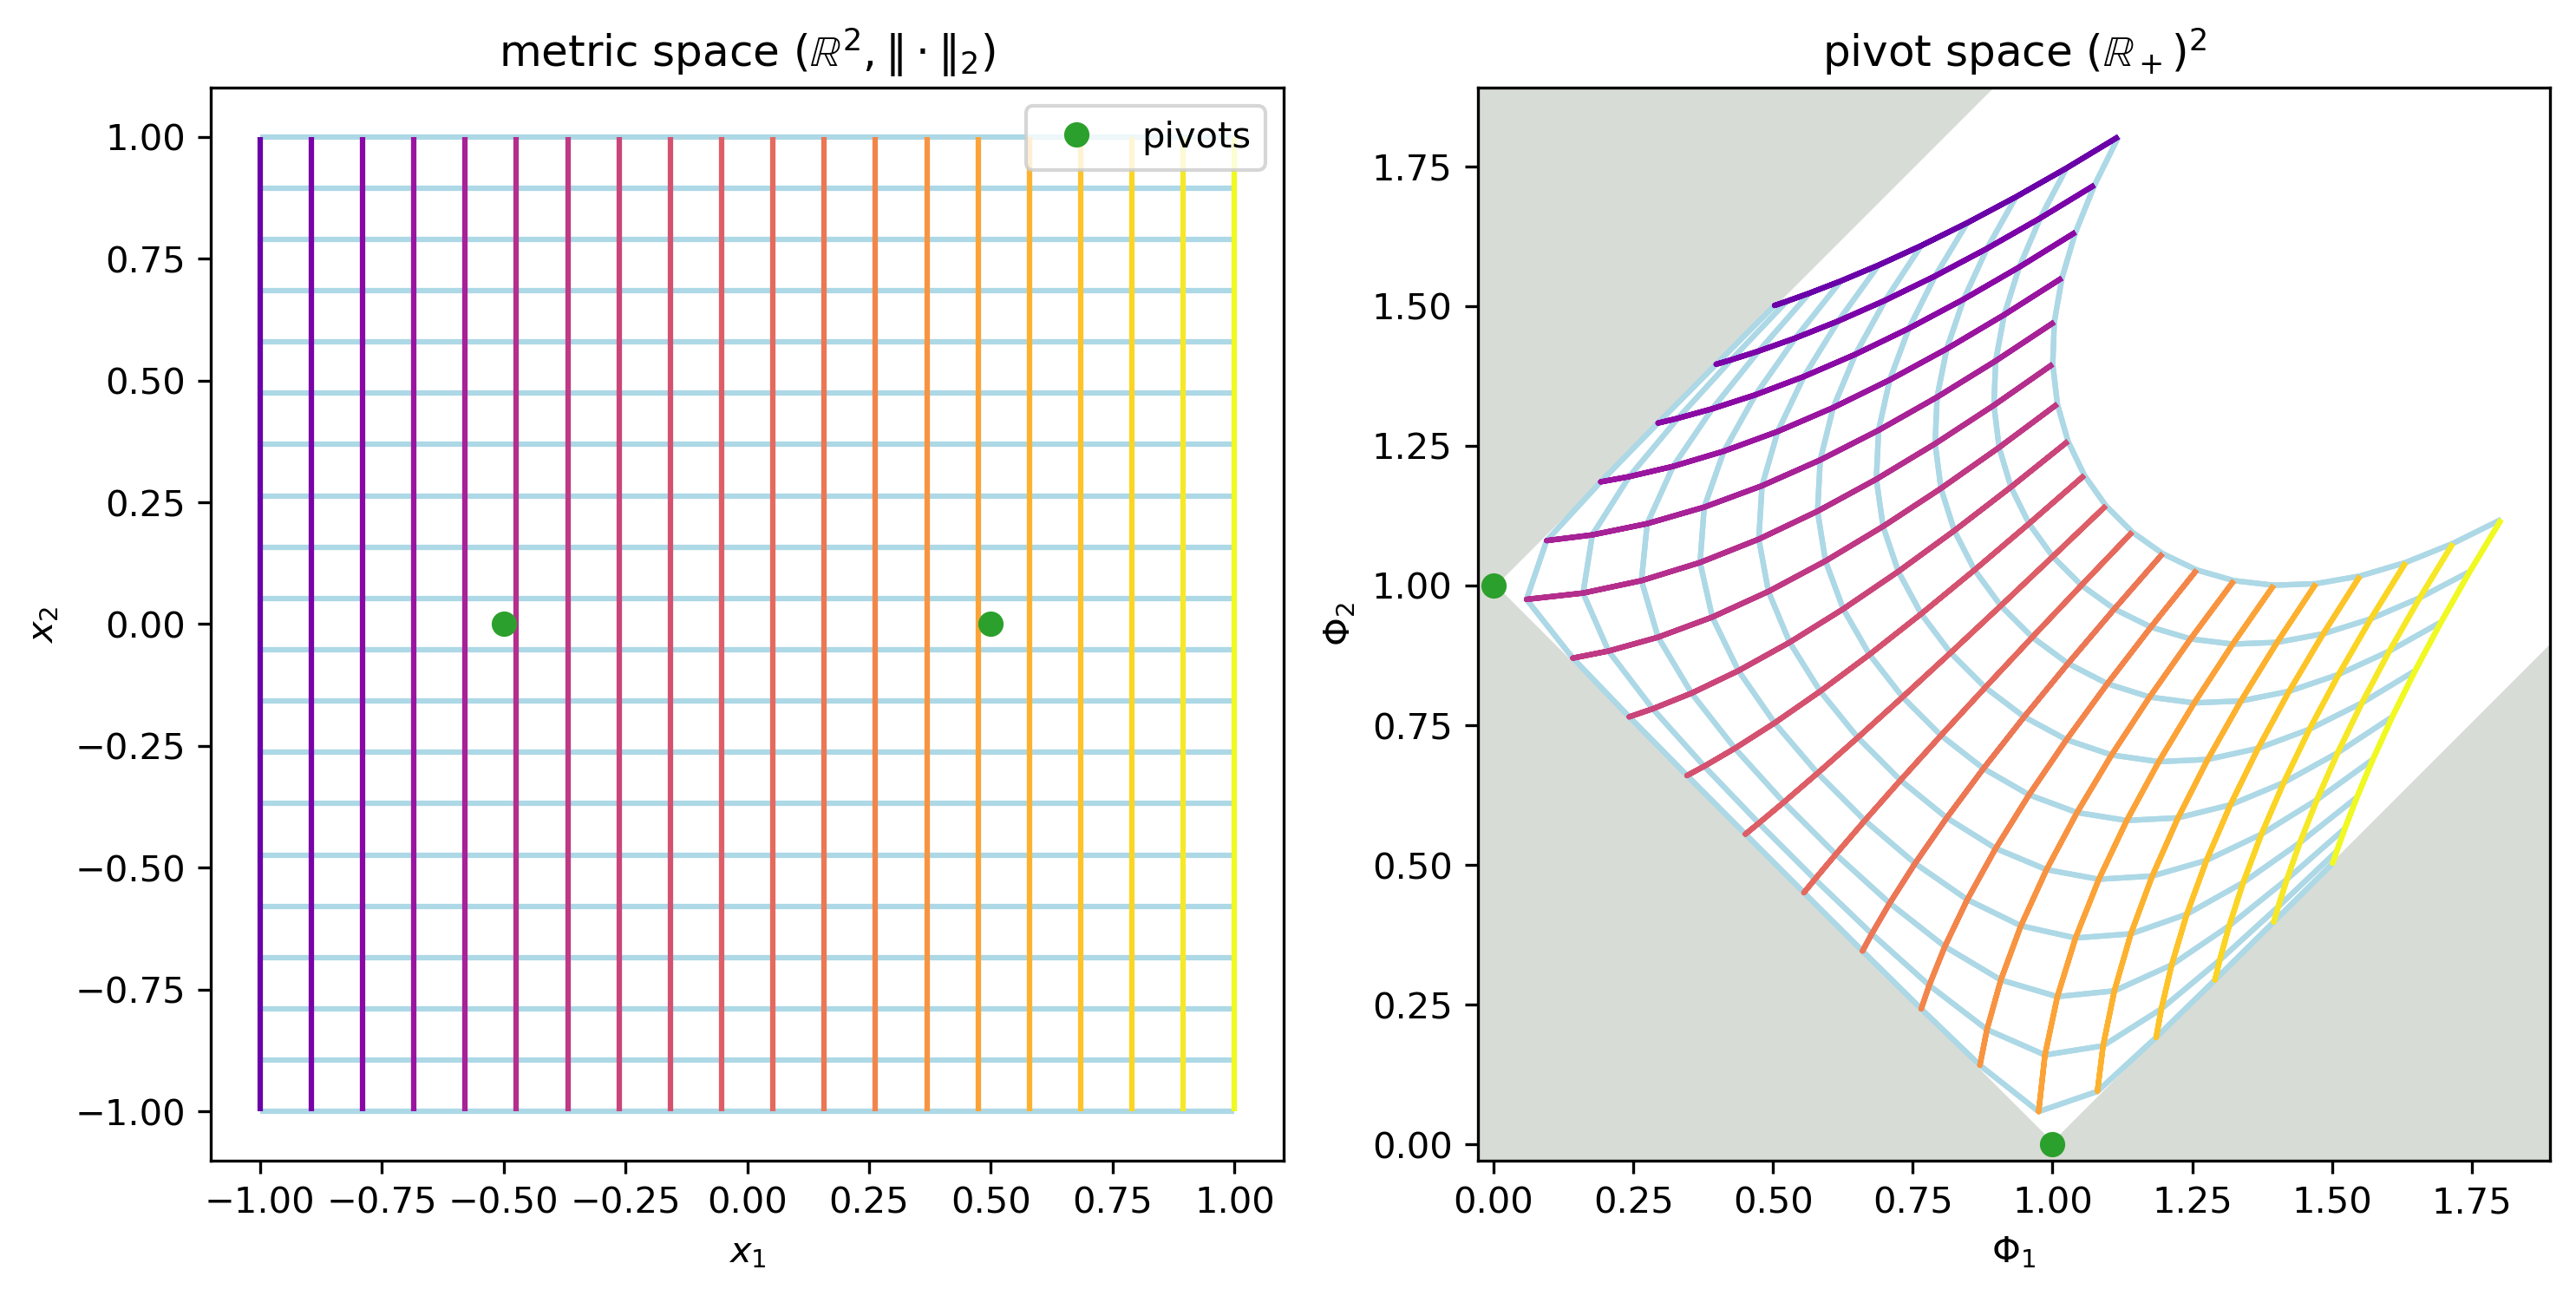

In [24]:
piv = PivotSpace(metric.Euclid(),pivots)

n = 20
xx, yy = np.meshgrid(np.linspace(-1,1, n), np.linspace(-1, 1,n))

points = np.array([xx.flatten(), yy.flatten()]).T
p_t = piv.transform_points(points)
xx_t, yy_t = p_t.T
xx_t = xx_t.reshape(xx.shape)
yy_t = yy_t.reshape(yy.shape)


cmap_1 = mpl.colormaps['plasma']
config = dict(
    ycolor = cmap_1(np.linspace(0.2,1, xx.shape[0])),
    xcolor = "lightblue",
)

plt.figure(figsize=(10,5), dpi=300)
plt.subplot(1,2,1)
plt.title(r"metric space $(\mathbb{R}^2, "+piv.metric.name+")$")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plot_grid(xx,yy, **config)
plt.plot(*pivots.T, "o", color="C2", label="pivots");
plt.ylim(-1.1,1.1)
plt.legend()
plt.gca().set_aspect('equal')

plt.subplot(1,2,2)
plt.title("pivot space $(\mathbb{R}_+)^2$")
plt.xlabel("$\Phi_1$")
plt.ylabel("$\Phi_2$")

plot_grid(xx_t,yy_t, **config)
mask_forbidden(pivots)
plt.plot(*piv.transform_points(pivots), "o", color="C2", label="pivots");

plt.gca().set_aspect('equal')

plt.tight_layout()
plt.savefig("/fig/r_2_pivot.svg")
plt.show()

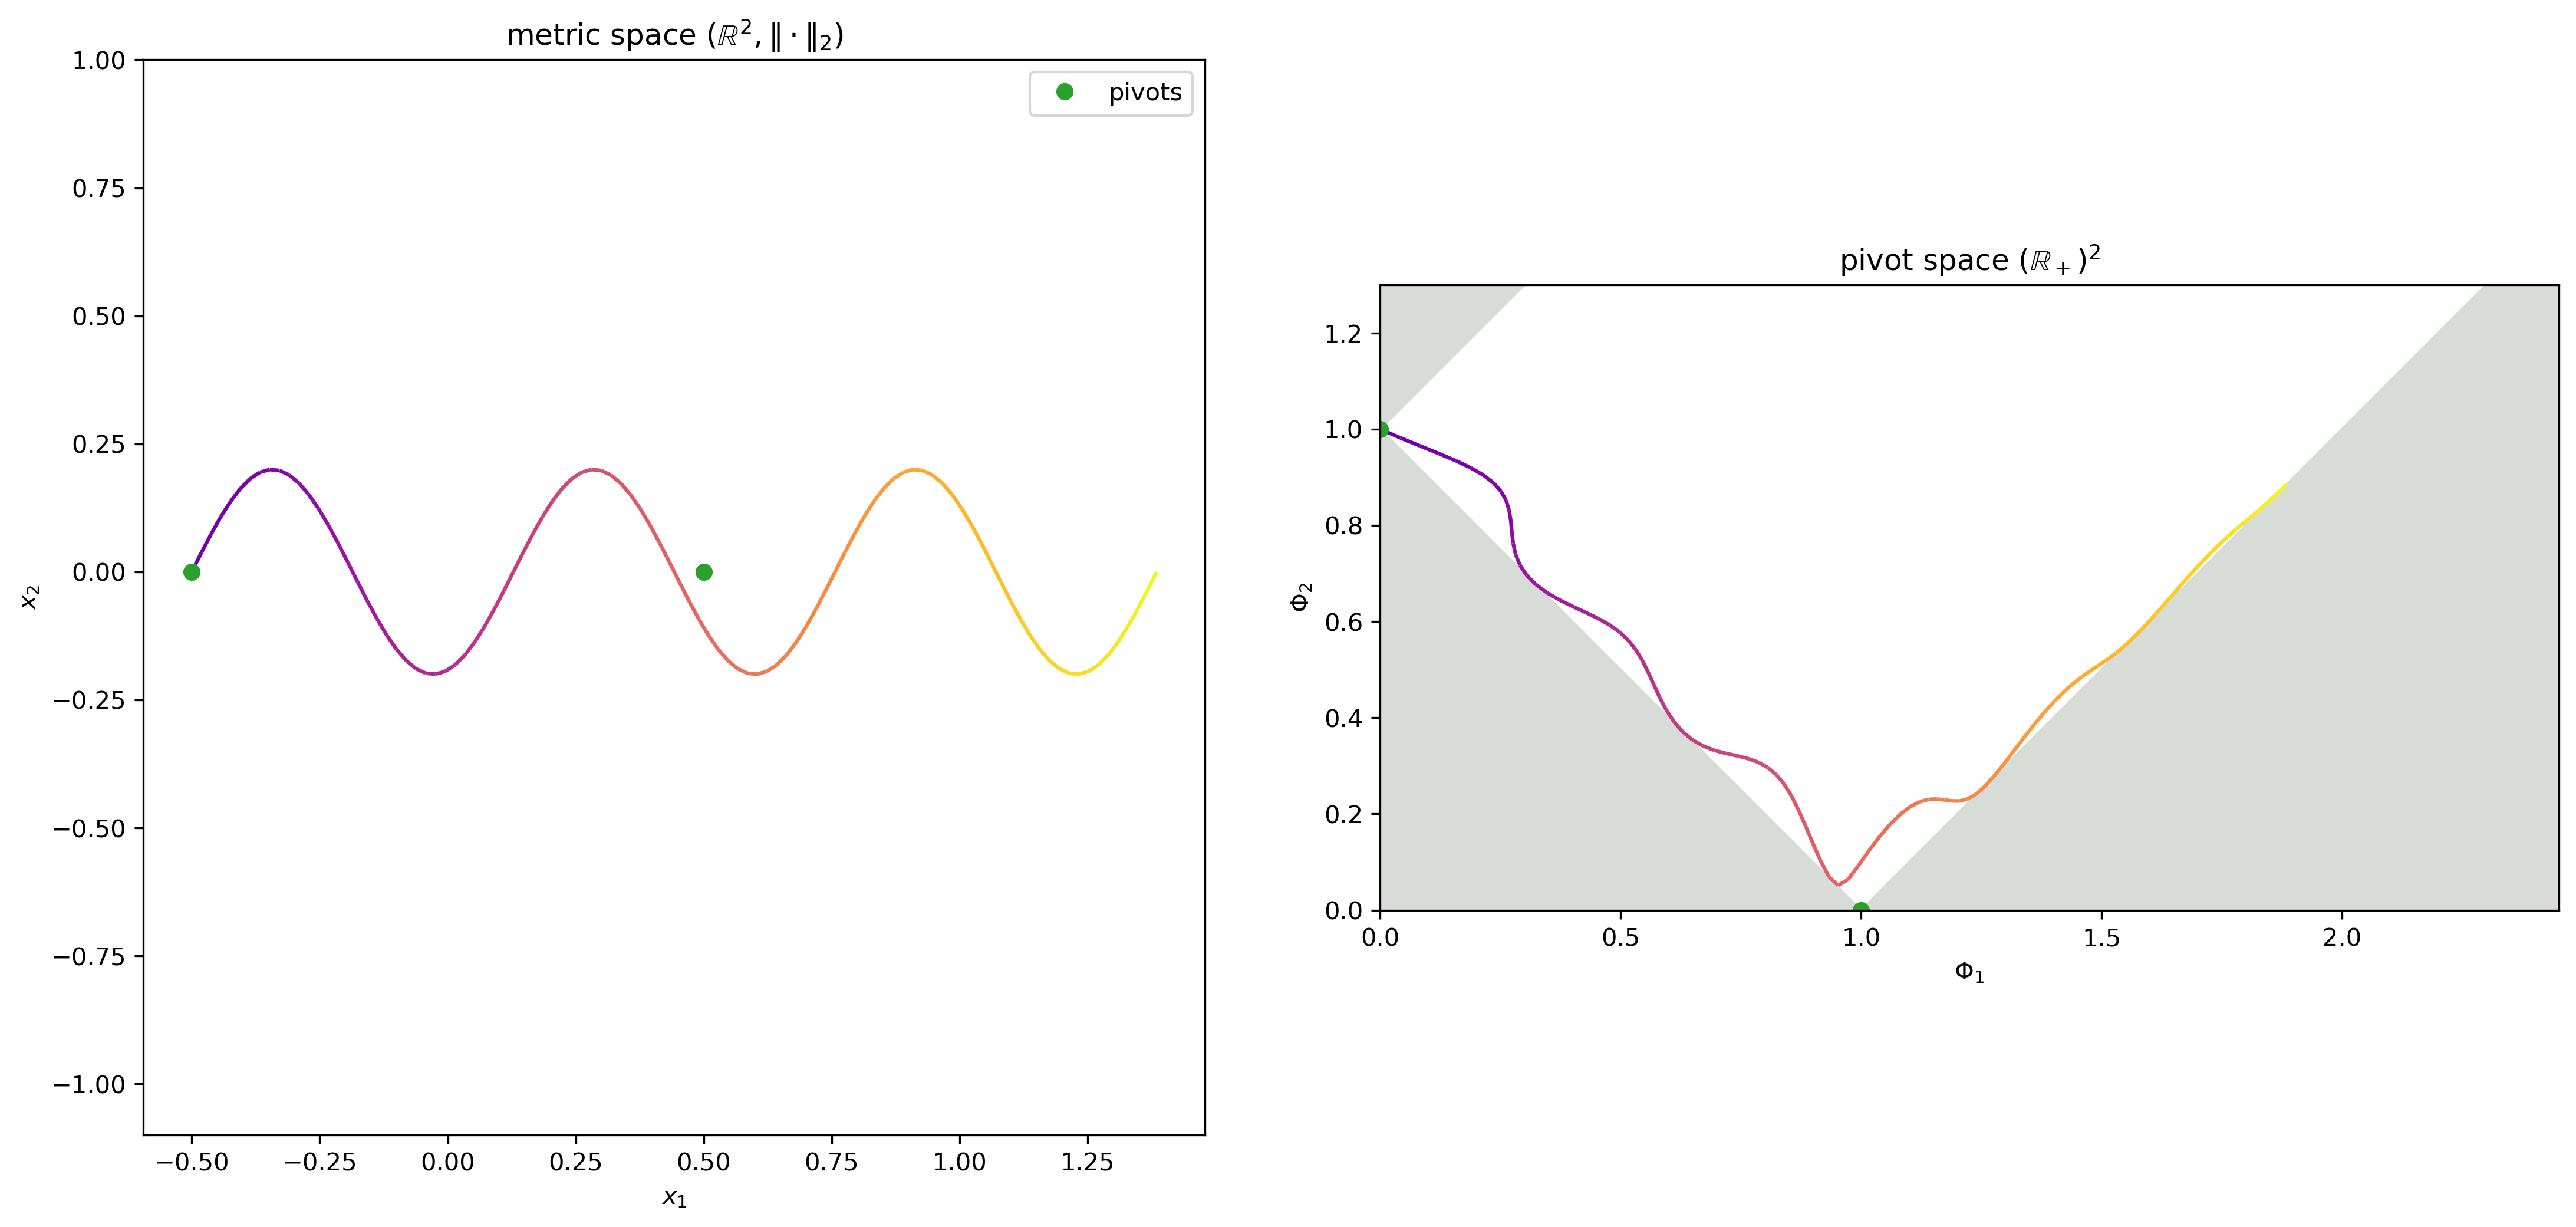

In [115]:
x = np.linspace(0, np.pi * 6, 100)
points = np.array([x/10-0.5,np.sin(x)/5]).T
p_t = piv.transform_points(points)

def plot_colored_line(points, cmap=None):
    if cmap is None:
        cmap = mpl.colormaps['plasma']
    colors = cmap(np.linspace(0.2,1, len(points)))
    points = points.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    #plt.plot(*points.T, color=colors)
    lc = LineCollection(segments, color=colors)
    plt.gca().add_collection(lc)

plt.figure(figsize=(15,7), dpi=300)
plt.subplot(1,2,1)
plt.title(r"metric space $(\mathbb{R}^2, "+piv.metric.name+")$")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plot_colored_line(points)

plt.plot(*pivots.T, "o", color="C2", label="pivots");


plt.ylim(-1.1,1)
plt.legend()
plt.gca().set_aspect('equal')

plt.subplot(1,2,2)
plt.title("pivot space $(\mathbb{R}_+)^2$")
plt.xlabel("$\Phi_1$")
plt.ylabel("$\Phi_2$")

plot_colored_line(p_t)
mask_forbidden(pivots)
plt.plot(*piv.transform_points(pivots), "o", color="C2", label="pivots");

plt.xlim(0, 1.3*max(p_t[:,0]))
plt.ylim(0, 1.3*max(p_t[:,1]))

plt.gca().set_aspect('equal')

plt.tight_layout()
plt.savefig("/fig/r_2_sin_1.svg")
plt.show()

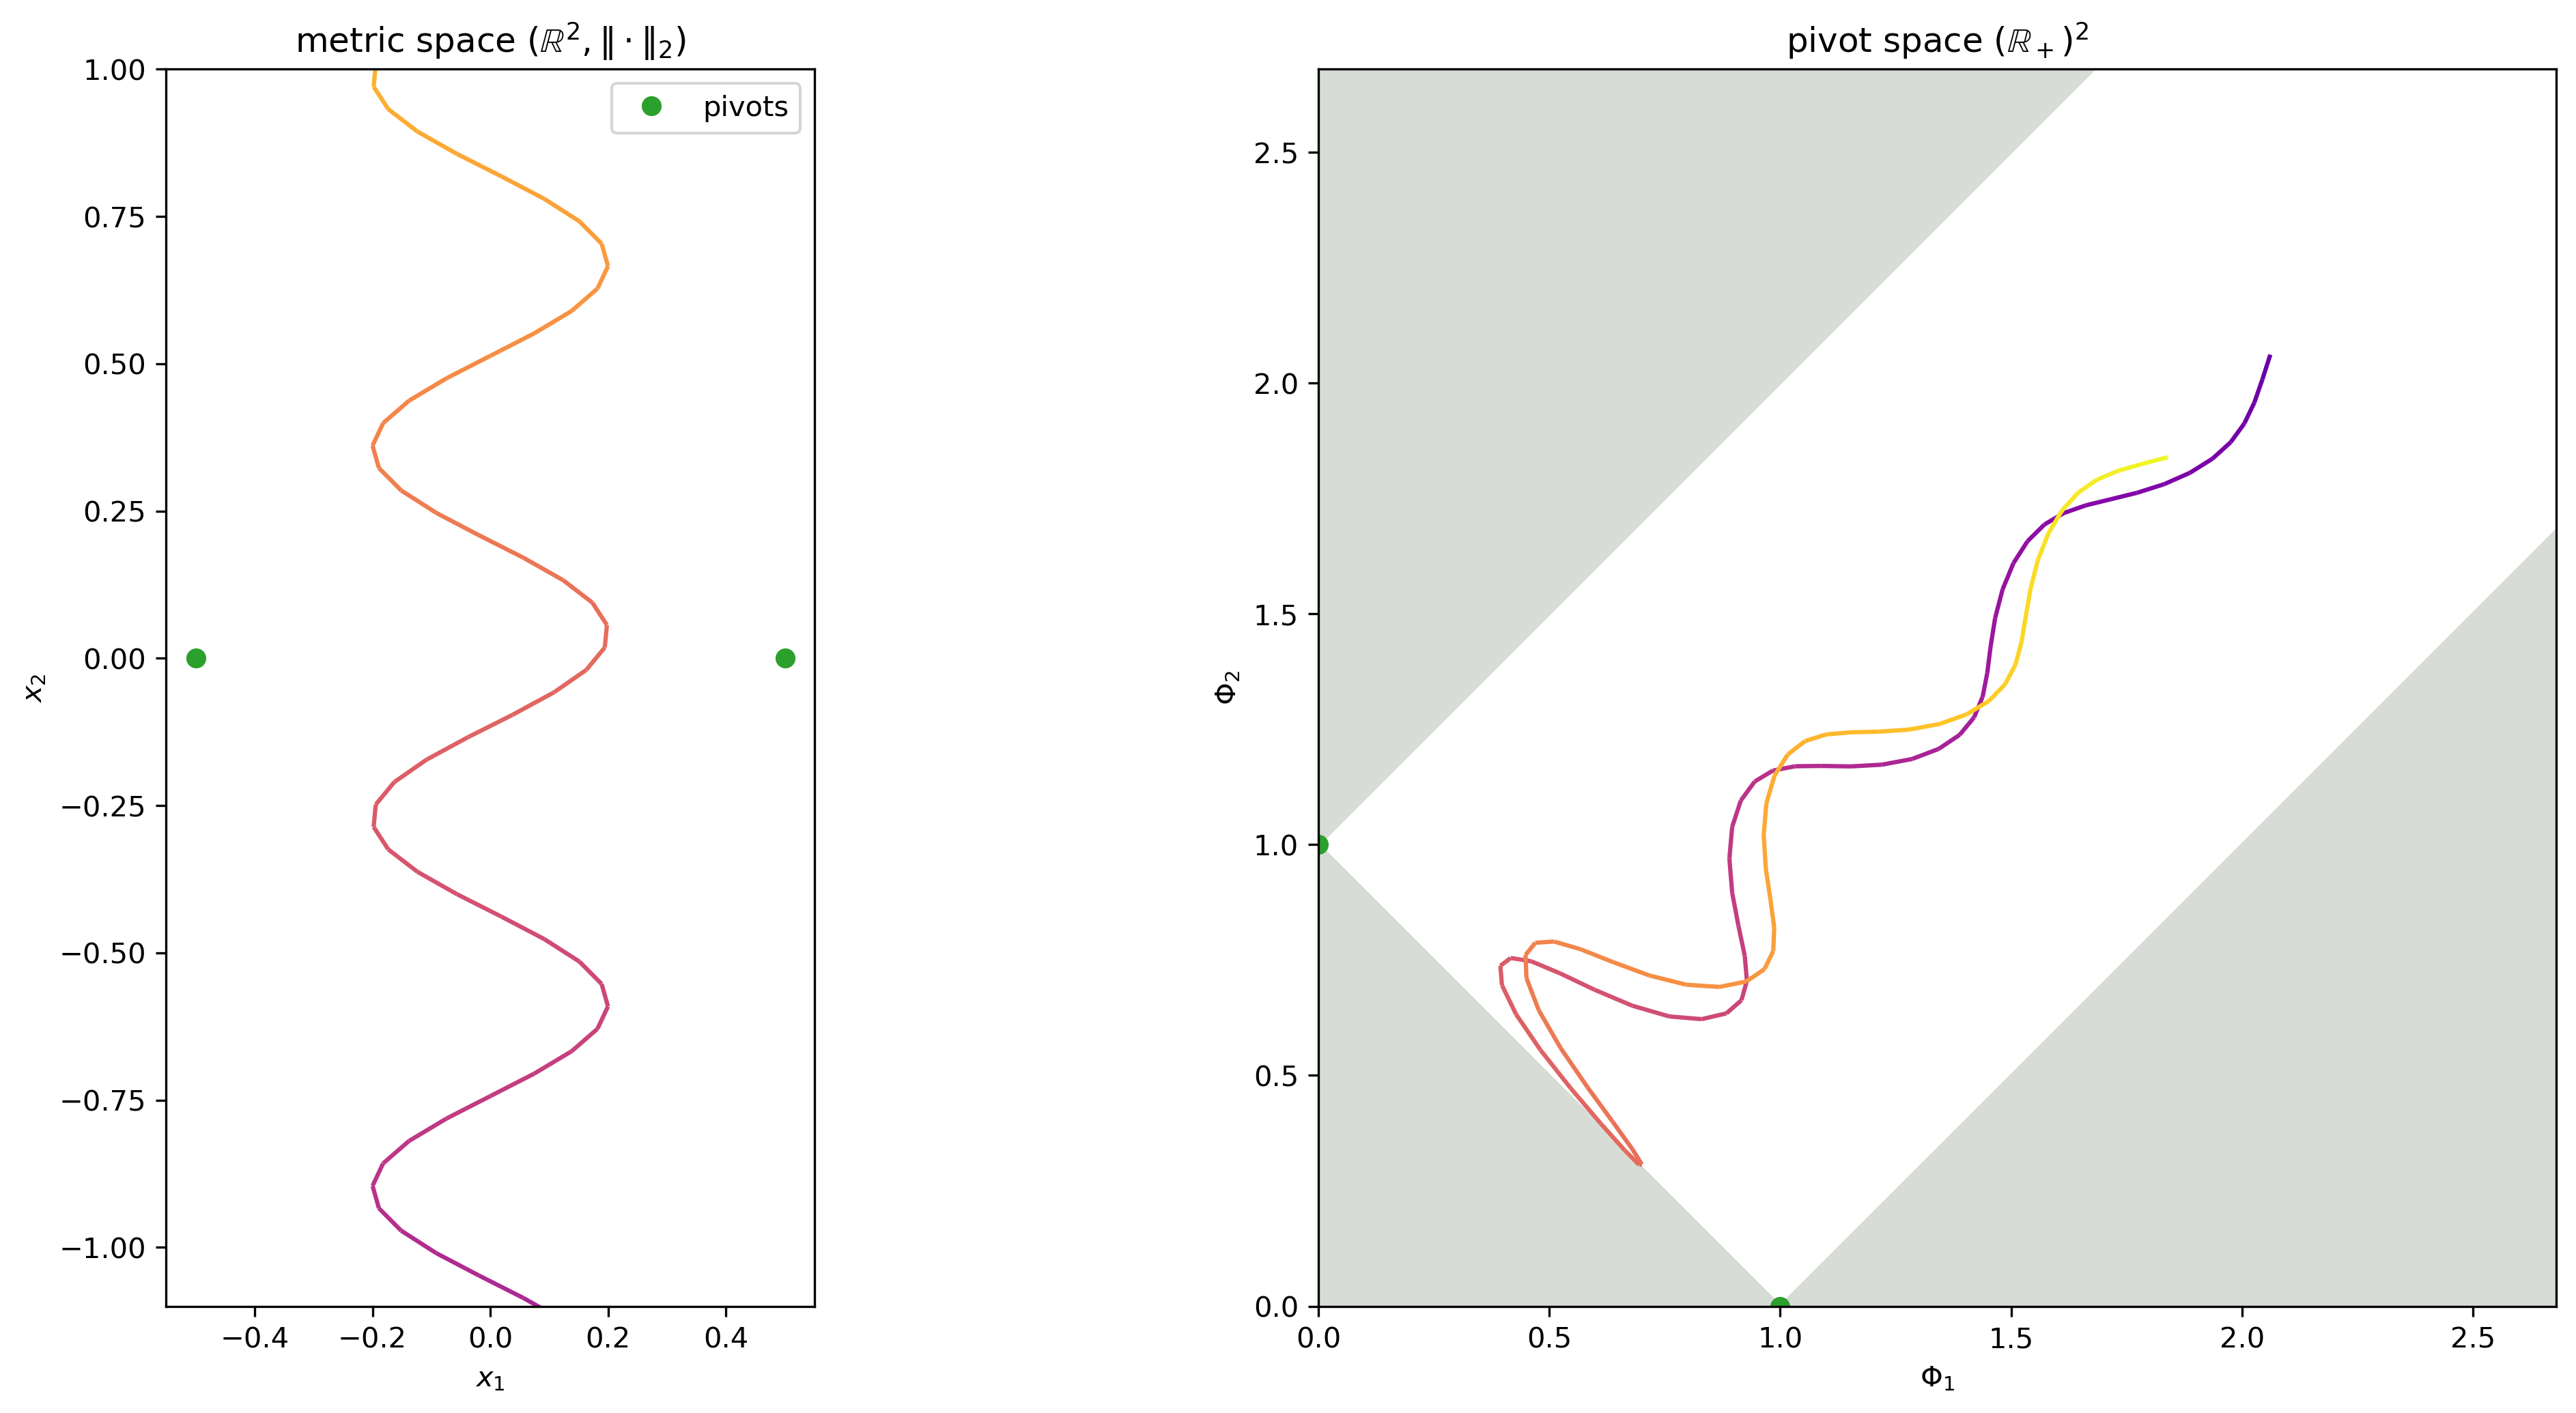

In [116]:
x = np.linspace(0, np.pi * 12, 100)
points = np.array([np.sin(x)/5, x/10-2]).T
p_t = piv.transform_points(points)


plt.figure(figsize=(15,7), dpi=300)
plt.subplot(1,2,1)
plt.title(r"metric space $(\mathbb{R}^2, "+piv.metric.name+")$")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plot_colored_line(points)

plt.plot(*pivots.T, "o", color="C2", label="pivots");


plt.ylim(-1.1,1)
plt.legend()
plt.gca().set_aspect('equal')

plt.subplot(1,2,2)
plt.title("pivot space $(\mathbb{R}_+)^2$")
plt.xlabel("$\Phi_1$")
plt.ylabel("$\Phi_2$")

plot_colored_line(p_t)
mask_forbidden(pivots)
plt.plot(*piv.transform_points(pivots), "o", color="C2", label="pivots");

plt.xlim(0, 1.3*max(p_t[:,0]))
plt.ylim(0, 1.3*max(p_t[:,1]))

plt.gca().set_aspect('equal')

plt.tight_layout()
plt.savefig("/fig/r_2_sin_2.svg")
plt.show()

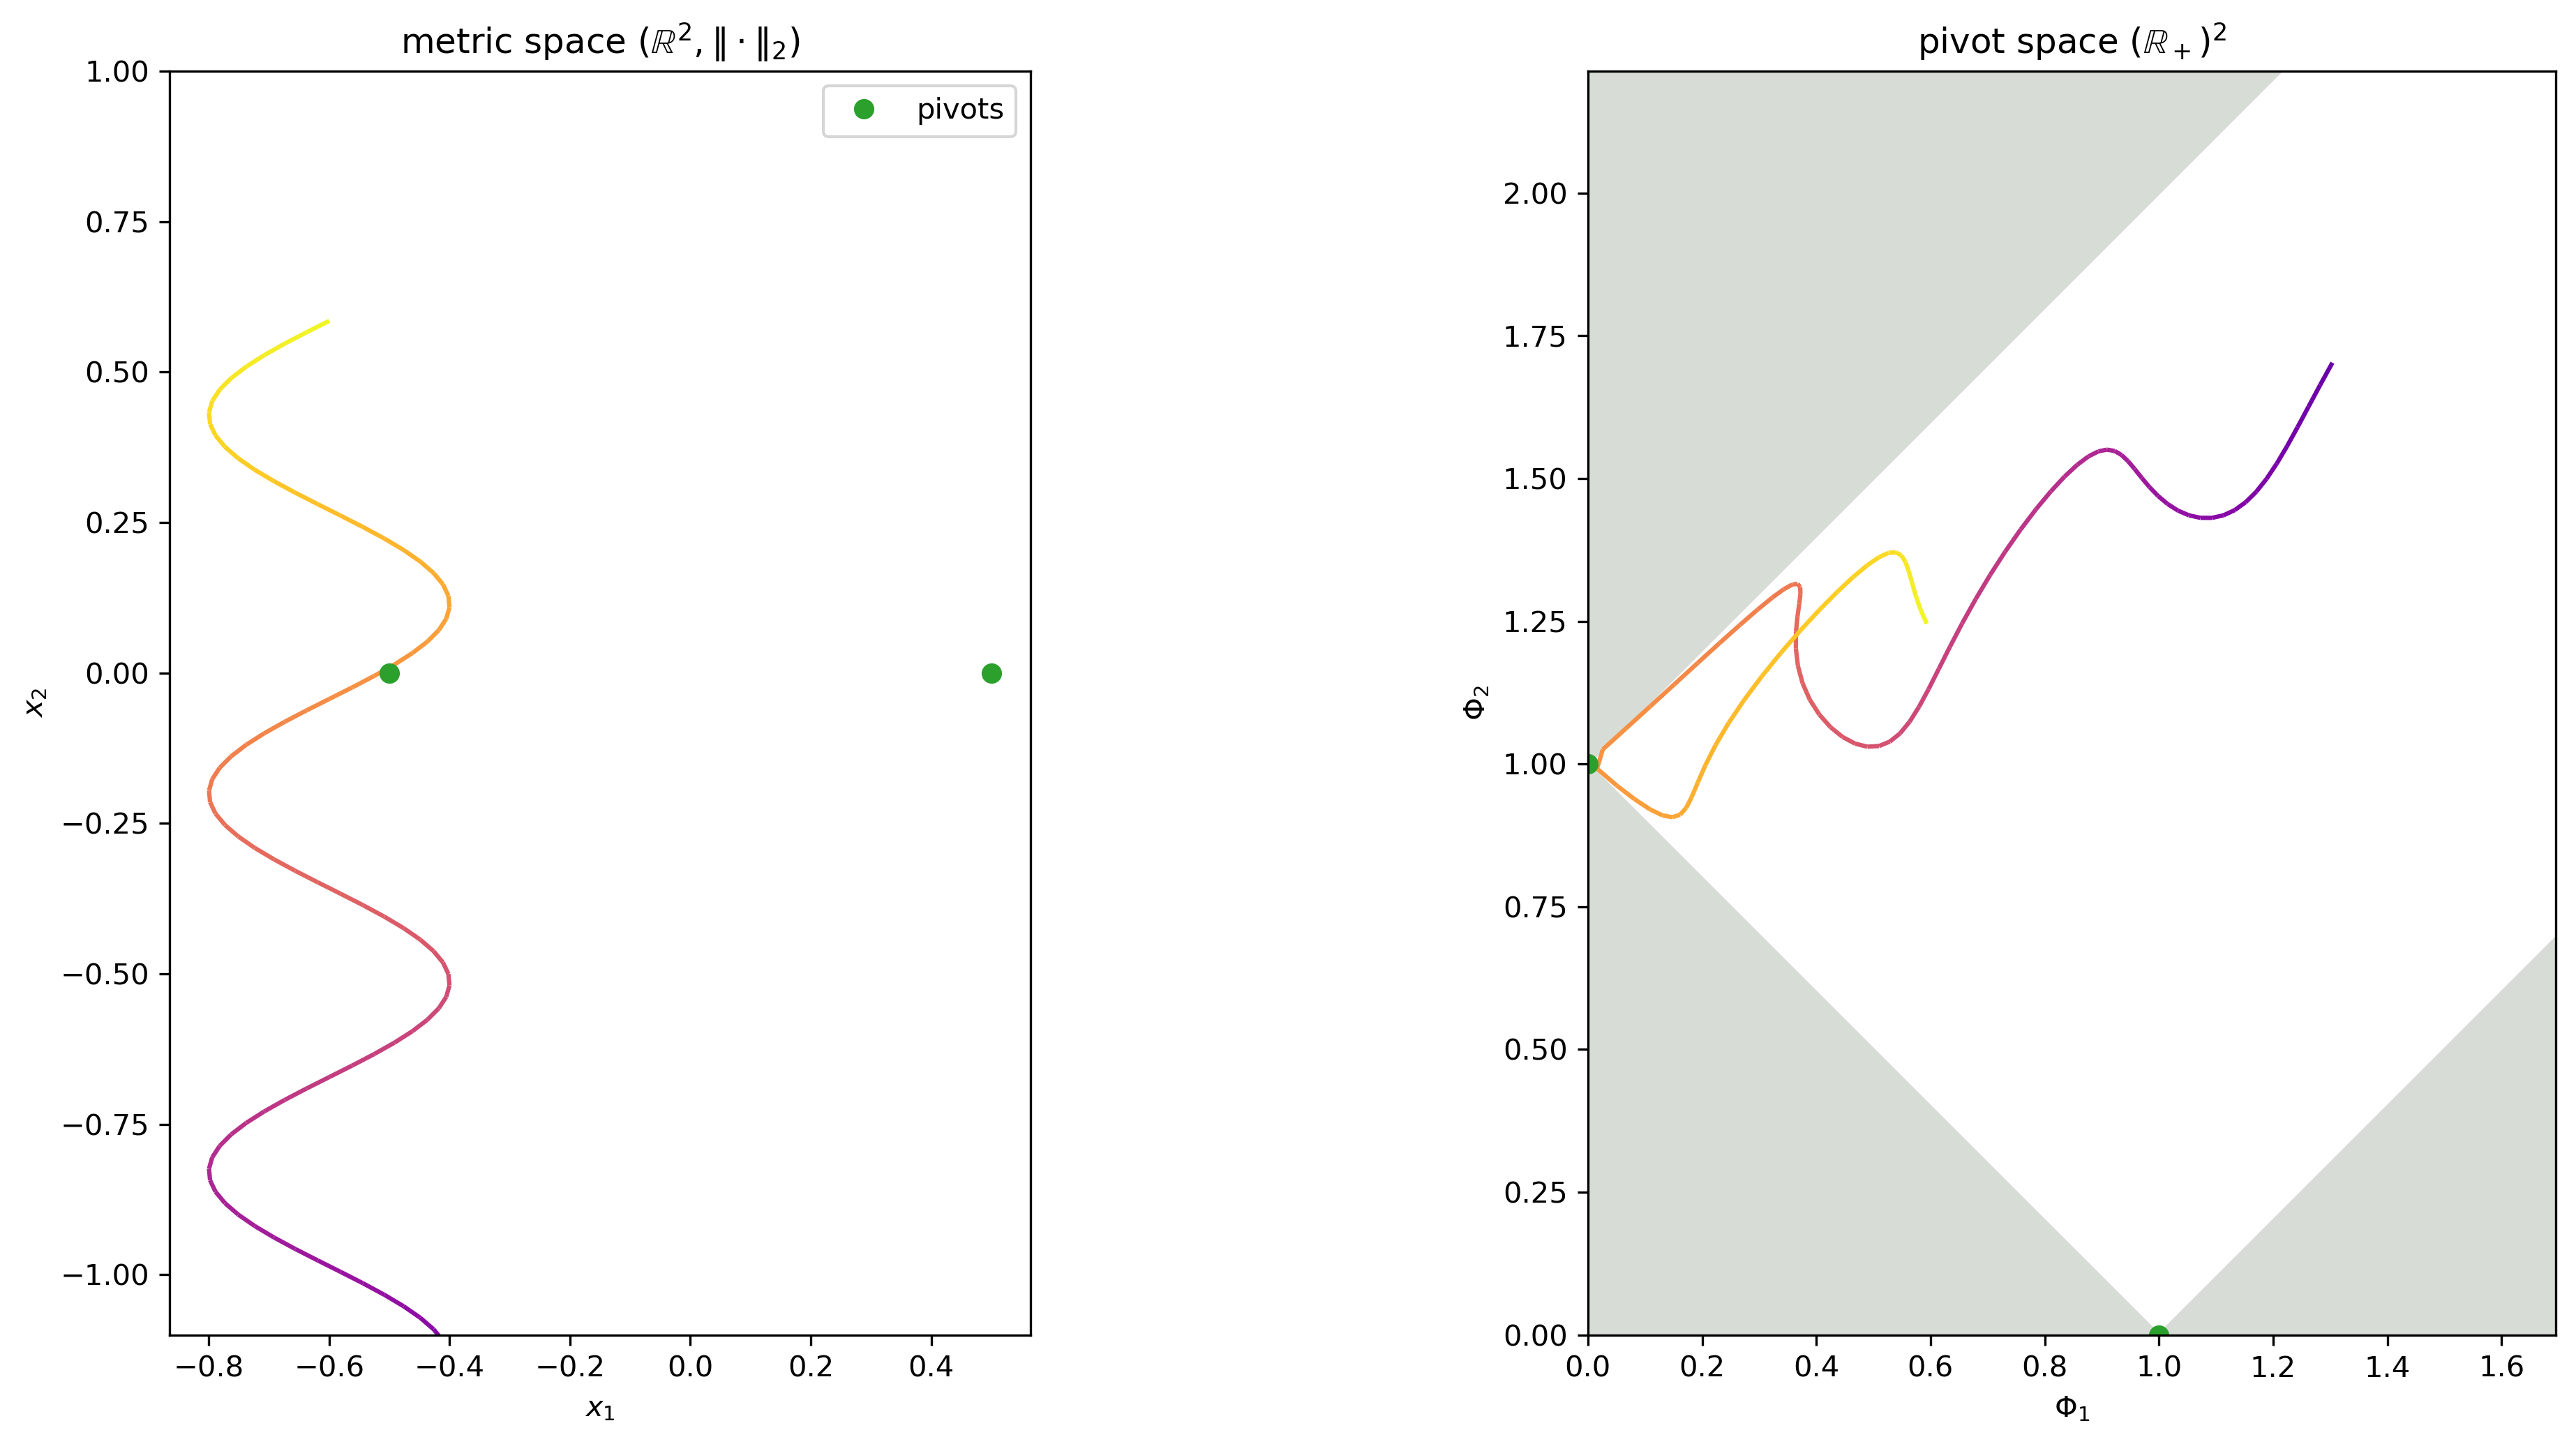

In [117]:
x = np.linspace(0, np.pi * 6, 100)
points = np.array([np.sin(x)/5-0.6, x/10-1.3]).T
p_t = piv.transform_points(points)


plt.figure(figsize=(15,7), dpi=300)
plt.subplot(1,2,1)
plt.title(r"metric space $(\mathbb{R}^2, "+piv.metric.name+")$")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plot_colored_line(points)

plt.plot(*pivots.T, "o", color="C2", label="pivots");


plt.ylim(-1.1,1)
plt.legend()
plt.gca().set_aspect('equal')

plt.subplot(1,2,2)
plt.title("pivot space $(\mathbb{R}_+)^2$")
plt.xlabel("$\Phi_1$")
plt.ylabel("$\Phi_2$")

plot_colored_line(p_t)
mask_forbidden(pivots)
plt.plot(*piv.transform_points(pivots), "o", color="C2", label="pivots");

plt.xlim(0, 1.3*max(p_t[:,0]))
plt.ylim(0, 1.3*max(p_t[:,1]))

plt.gca().set_aspect('equal')

plt.tight_layout()
plt.savefig("/fig/r_2_sin_3.svg")
plt.show()

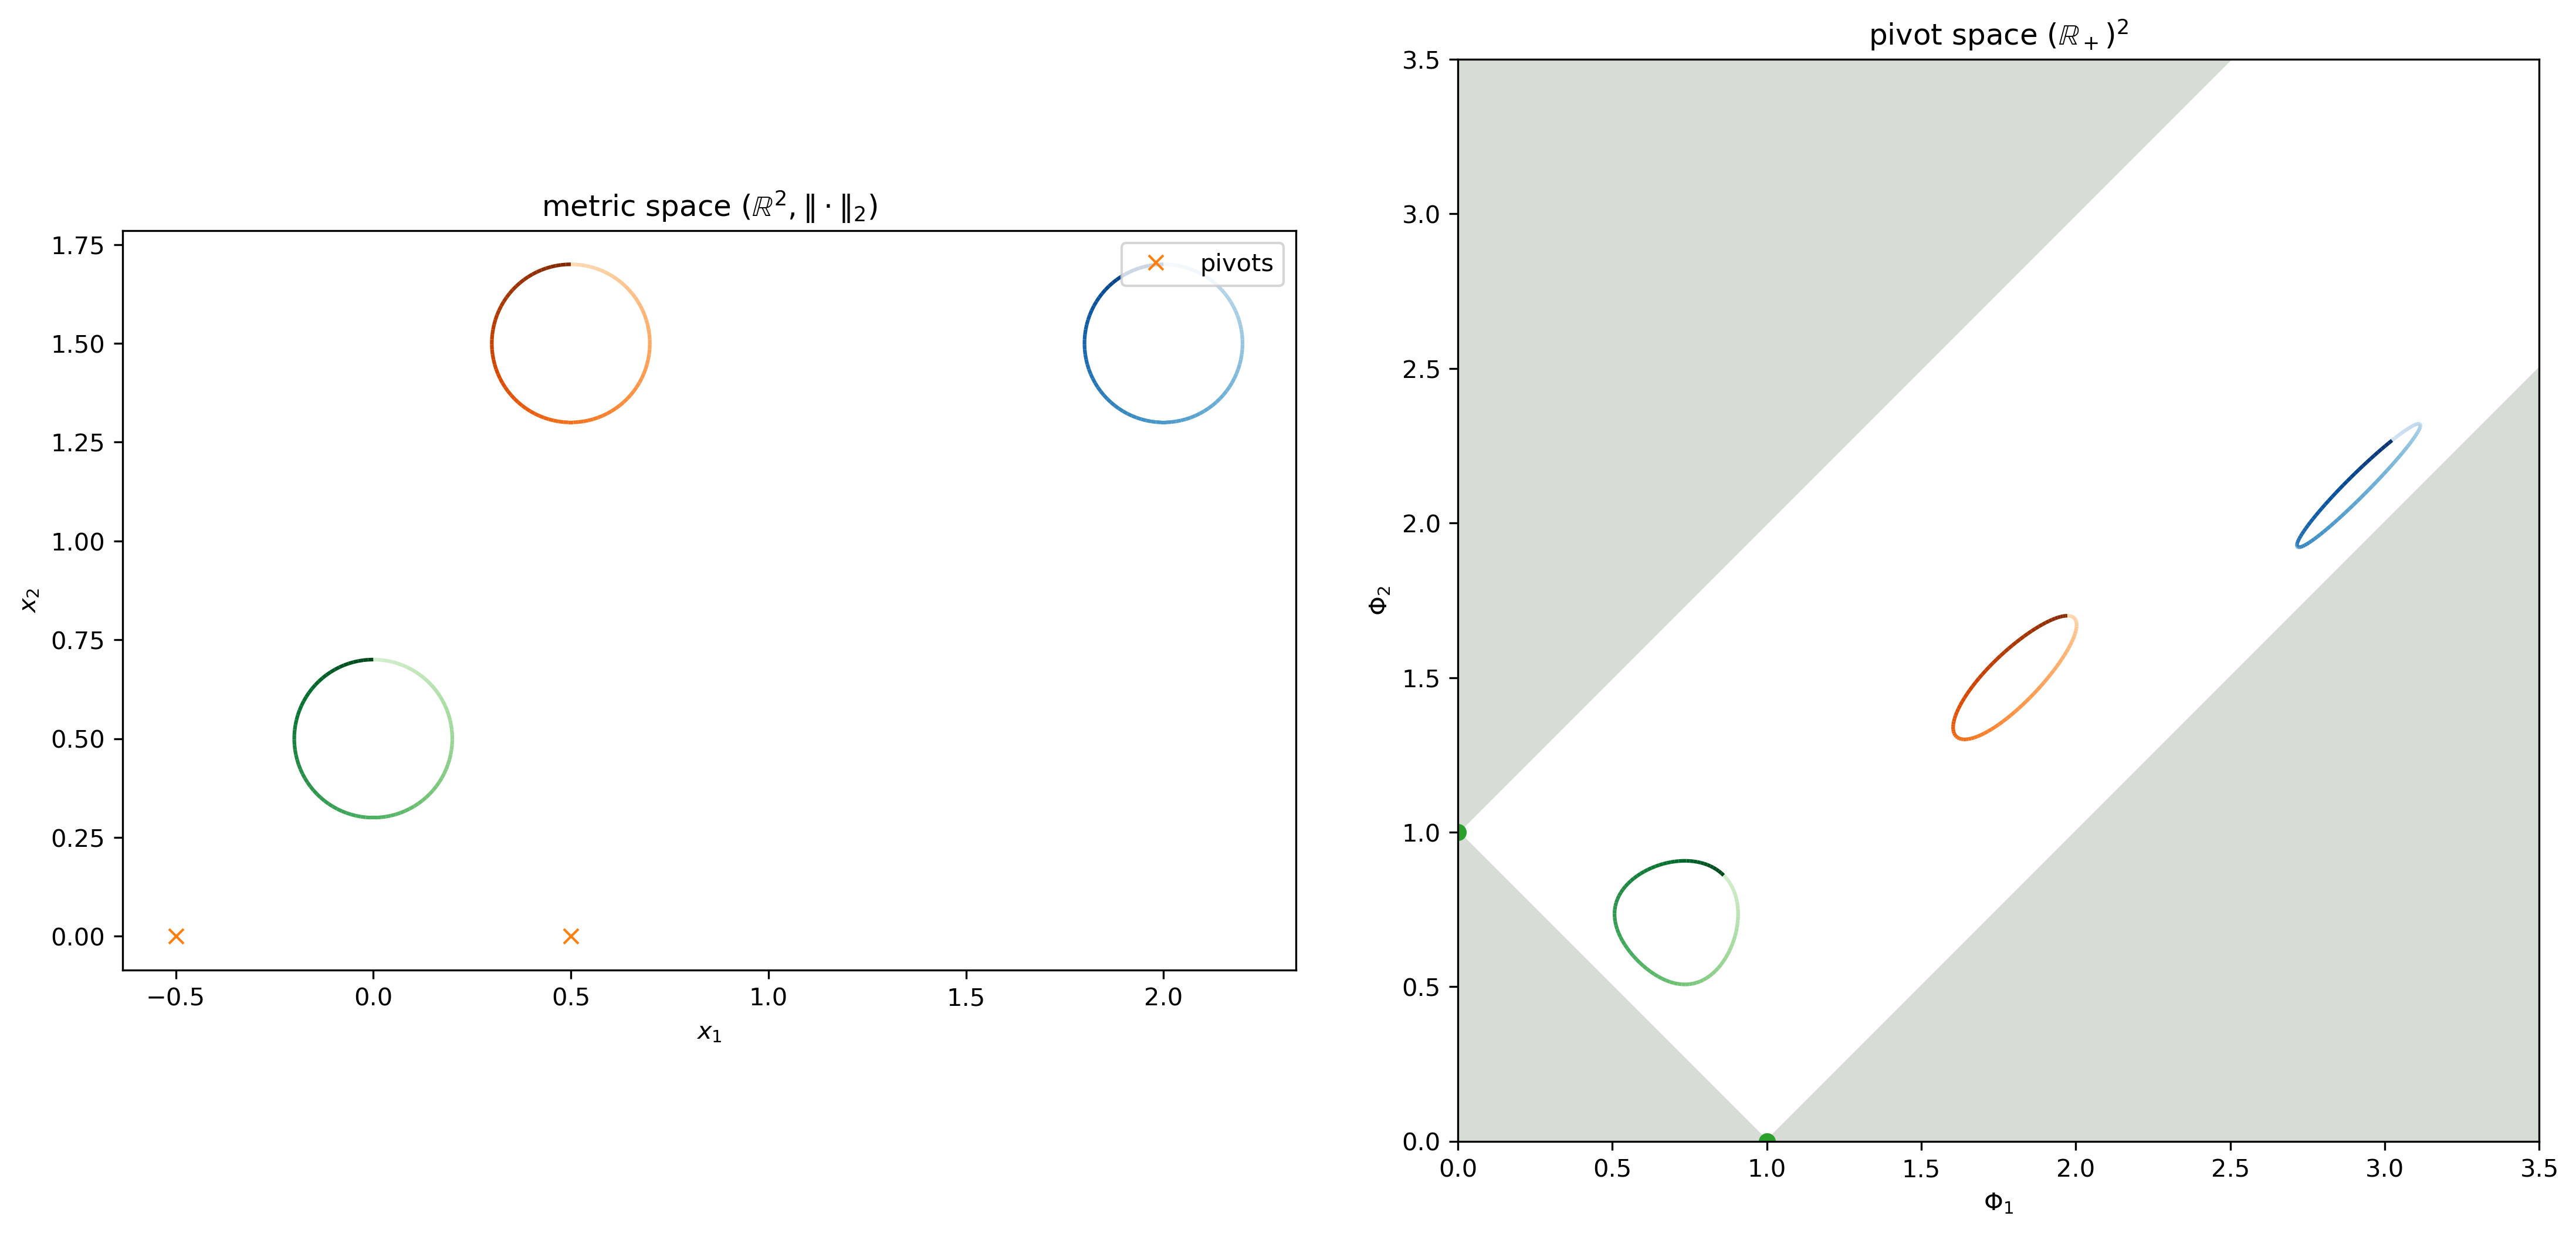

In [114]:
def get_circle(center=(1,2)):
    center = np.array(center)
    x = np.linspace(0, np.pi * 2, 100)
    r = 0.2
    points = center + np.array([r*np.sin(x), r*np.cos(x)]).T
    points_transformed = piv.transform_points(points)
    return points, points_transformed

cmaps = ["Blues","Oranges","Greens"]
cmaps = [mpl.colormaps[c] for c in cmaps]
circles = [
    get_circle((2,1.5)),
    get_circle((0.5,1.5)),
    get_circle((0,0.5)),
]

plt.figure(figsize=(15,7), dpi=300)
plt.subplot(1,2,1)
plt.title(r"metric space $(\mathbb{R}^2, "+piv.metric.name+")$")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

for (points,_),cmap in zip(circles, cmaps):
    plot_colored_line(points, cmap)

plt.plot(*pivots.T, "x", color="C1", label="pivots");


plt.legend()
plt.gca().set_aspect('equal')

plt.subplot(1,2,2)
plt.title("pivot space $(\mathbb{R}_+)^2$")
plt.xlabel("$\Phi_1$")
plt.ylabel("$\Phi_2$")

for (_,points_transformed),cmap in zip(circles, cmaps):
    plot_colored_line(points_transformed, cmap)
    
mask_forbidden(pivots)
plt.plot(*piv.transform_points(pivots), "o", color="C2", label="pivots");

plt.xlim(0, 3.5)
plt.ylim(0, 3.5)

plt.gca().set_aspect('equal')

plt.tight_layout()
plt.savefig("/fig/r_2_queries.svg")
plt.show()

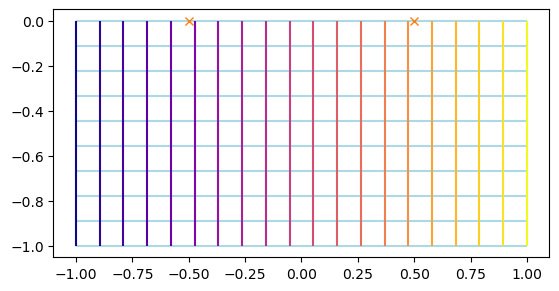

In [22]:


n = 20
xx, yy = np.meshgrid(np.linspace(-1,1, n), np.linspace(-1,0,n//2))

cmap_1 = mpl.colormaps['plasma']
cmap_2 = mpl.colormaps['gray']

xcolor = cmap_1(np.linspace(0.2,1, xx.shape[0]))
ycolor = cmap_1(np.linspace(0,1, yy.shape[0]*2))

plot_grid(xx,yy, ycolor=ycolor, xcolor="lightblue")

plt.plot(*pivots.T, "x", color="C1", label="pivots");
plt.gca().set_aspect('equal')
plt.show()

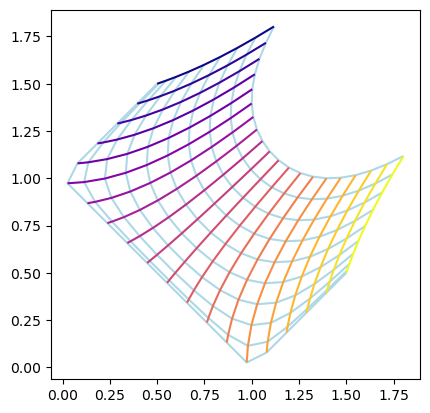

In [23]:
points = np.array([xx.flatten(), yy.flatten()]).T
p_t = points_to_pivot_space(points, pivots)
xx_t, yy_t = p_t.T
xx_t = xx_t.reshape(xx.shape)
yy_t = yy_t.reshape(yy.shape)

plot_grid(xx_t,yy_t, ycolor=ycolor, xcolor="lightblue")
plt.gca().set_aspect('equal')
plt.show()